<h1 style='text-align:center; color:#1F51FF'><b> Sentiment Analysis on Social Reviews </b></h1>

📌 **By:** Akmal Falah Darmawan  
🎓 **Role:** Data Science Student  
👥 **Stakeholder:** Quality Assurance 

![background](bg.jpeg)

<h1 style='text-align:left; color:#1F51FF; font-size: 24px'><b> Sesi 1: Business Understanding </b></h1>

#### **Latar Belakang**

Jumlah ulasan pelanggan meningkat seiring pertumbuhan produk. Ulasan tersebut mengandung indikasi masalah kualitas (bug, performa lambat, pengalaman tidak konsisten) yang sering terlambat terdeteksi jika hanya mengandalkan laporan manual. Sistem analisis sentimen ini dibangun untuk membantu QA mengidentifikasi dan memprioritaskan keluhan lebih cepat, sehingga siklus perbaikan (detect → triage → fix → verify) menjadi lebih efektif.

#### **Tujuan Bisnis**
- Deteksi dini keluhan yang berkaitan dengan kualitas produk dari kanal ulasan/komentar.
- Prioritisasi penanganan dengan menandai prediksi berisiko (negatif) dan berkeyakinan rendah untuk pemeriksaan manual.
- Peningkatan kualitas rilis melalui umpan balik terstruktur ke tim pengembang dan product owner.

<h1 style='text-align:left; color:#1F51FF; font-size: 24px'><b> Sesi 2: Data Understanding </b></h1>

#### **Import Libary**

In [1]:
import warnings, re, joblib
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import inspect

from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, fbeta_score, accuracy_score, classification_report, confusion_matrix, recall_score

from sklearn.base import BaseEstimator, TransformerMixin
from scipy import sparse

#### **Load Dataset**

In [2]:
# ----------------- 1) LOAD -----------------

DATA_PATH = "dataset.csv"
def load_csv_any(path):
    try:    return pd.read_csv(path)
    except UnicodeDecodeError:
        return pd.read_csv(path, encoding="latin-1")

df = load_csv_any(DATA_PATH)
assert {"product_name","review_text","sentiment"}.issubset(df.columns), \
    "Kolom wajib tidak ditemukan: product_name, review_text, sentiment"
print("Raw shape:", df.shape)


Raw shape: (2194, 3)


In [3]:
df.head()

,product_name,review_text,sentiment
0,Basic Online Course Learning (BOCL),"Materinya goks abis, auto paham! Instrukturnya...",2.0
1,Premium Online Learning (POL),"Platformnya anjay, interaktif banget, jadi gak...",2.0
2,Private Online Course Learning (POCL),"Mentornya pro player, ngajarnya santuy tapi ng...",2.0
3,Onsite Course Learning (OCL),"Sumpah, ini kursus paling oke! Ilmunya kepake ...",2.0
4,Private Course Onsite Learning (PCOL),Sertifikatnya nampol buat naikin CV. Vibes bel...,2.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2194 entries, 0 to 2193
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  2194 non-null   object 
 1   review_text   2194 non-null   object 
 2   sentiment     2193 non-null   float64
dtypes: float64(1), object(2)
memory usage: 51.6+ KB


In [5]:
df.shape

(2194, 3)

In [6]:
df.isna().sum().sort_values(ascending=False)

sentiment       1
product_name    0
review_text     0
dtype: int64

<h1 style='text-align:left; color:#1F51FF; font-size: 24px'><b> Section 3: Data Preparation & Preprocessing </b></h1>

In [7]:
RANDOM_SEED          = 42
MODEL_PATH           = "sentiment_pipeline_group.joblib"
NEG_CLASS_WEIGHT     = 2.3     
NEG_PROBA_THRESHOLD  = 0.40    

**Cleaning Data**

In [8]:
STOPWORDS = set("""
a an and are as at be by for from has have if in into is it its of on or that the
their there they this to was will with
aku saya kamu kalian kita mereka dia ia ku mu nya
yang dan di ke dari untuk pada adalah itu ini
ada para saja atau serta sehingga karena namun tapi jadi maka
dengan tentang sebagai juga sudah belum masih hanya lebih kurang suatu tiap setiap
""".split())

# pastikan kata negasi TIDAK termasuk stopwords
NEGATORS = {"tidak","bukan","tak","no","not","n't","ga","gak","nggak","enggak","jangan"}
STOPWORDS = STOPWORDS.difference(NEGATORS)

SLANG = {
    "bgt":"banget","bngt":"banget","gk":"gak","ga":"gak","nggak":"gak","ngga":"gak",
    "rekomen":"rekomendasi","mantul":"mantap","anjir":"anjir","anjay":"anjay",
    "mager":"malas","ok":"oke","cs":"customer_service"
}
EMOJI_POS = {"🙂","😊","😁","😍","👍","🎉","🔥","😘","🤩","👌"}
EMOJI_NEG = {"😡","🤬","😞","😠","👎","😢","😭","💀","🤢","😫"}

- Stopwords: daftar kata umum (mis. yang, dan, di) untuk dibuang agar fitur lebih fokus.
- Negators: tidak/bukan/ga/gak/nggak/dll tidak dibuang dari stopwords supaya konteks “tidak bagus” tetap terbaca.
- Slang Map: pemetaan bahasa gaul → baku (mis. bgt→banget, mager→malas, ok→oke) agar frekuensi kata tidak terpecah.
- Emoji Sentiment: kelompok emoji positif/negatif sebagai sinyal emosi (bisa dihitung atau dijadikan token khusus).

In [9]:
PHRASE_MAP = {
    r"\bred flag\b": " red_flag ",
    r"\btidak (rekomendasi|direkomendasikan)\b": " tidak_rekomendasi ",
    r"\b(gak|ga|gk|enggak|nggak)\s+s(es)?uai\b": " gak_sesuai ",
    r"\bskip dulu\b": " skip_dulu ",
    r"\b(respon|response)\s+(buruk|lama|lambat)\b": " respon_buruk ",
}

PHRASE_MAP.update({
    r"\bso[-\s]?so\b": " so_so ",
    r"\bb\s*aja\.?\b": " biasa ",
    r"\bnyesel\b": " menyesal ",
    r"\bzonk\b": " zonk ",
    r"\bampas\b": " ampas ",
    r"\b(mahal|kemahalan)\b": " mahal ",
    r"\blag(ging)?\b": " lag ",
    r"\brespon\s*(lama|lambat)\b": " respon_buruk ",
})


POS_LEXICON = {
    "bagus","keren","mantap","mantapjiwa","top","oke","wow","worth","worthit",
    "recommended","rekomendasi","puas","memuaskan","terbaik","cepat","ramah",
    "bantu","solutif","jelas","mudah","stabil","rapi","aman","bagusbanget"
}
NEG_LEXICON = {
    "jelek","buruk","parah","zonk","ampas","mahal","lambat","lemot","lelet",
    "bohong","tipu","menyesal","kecewa","ga_sopan","tidak_sopan","respon_buruk",
    "error","bug","crash","ribet","susah","bawel","cerewet","nyebelin",
    "busuk","amis","bau","bau_mulut","bau_badan","jorok","jijik","menjijikkan","lag"
}
NEU_LEXICON = {
    "biasa","so_so","lumayan","standar","cukup","seadanya","netral","overall"
}

In [10]:
class LexiconFeaturizer(BaseEstimator, TransformerMixin):
    """Ekstrak fitur leksikon percakapan: hitung jumlah kata POS/NEG/NEU + tanda seru."""
    def __init__(self, pos=None, neg=None, neu=None):
        self.pos = set(pos or []); self.neg = set(neg or []); self.neu = set(neu or [])
    def fit(self, X, y=None): return self
    def transform(self, X):
        rows = []
        for s in X:
            toks = str(s).split()
            ts = set(toks)
            pos_cnt = len(ts & self.pos)
            neg_cnt = len(ts & self.neg)
            neu_cnt = len(ts & self.neu)
            exclaim = 1 if "!" in str(s) else 0
            rows.append([pos_cnt, neg_cnt, neu_cnt, exclaim])
        return sparse.csr_matrix(rows, dtype=float)

def clean_text(s: str) -> str:
    s = str(s).lower()

    # 1) Gabungkan frasa penting jadi satu token
    for pat, repl in PHRASE_MAP.items():
        s = re.sub(pat, repl, s, flags=re.IGNORECASE)

    # 2) Emoji → token
    for e in EMOJI_POS: s = s.replace(e, " EMO_POS ")
    for e in EMOJI_NEG: s = s.replace(e, " EMO_NEG ")

    # 3) Hapus url/mention/hashtag (kata hashtag disimpan)
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"@\w+", " ", s)
    s = re.sub(r"#(\w+)", r" \1 ", s)

    # 4) Tokenisasi: pertahankan underscore (_)
    toks = re.findall(r"[a-zA-Zá-ž_]+", s)

    # 5) Normalisasi slang & buang stopword (negator sudah dikeluarkan dari STOPWORDS)
    toks = [SLANG.get(t, t) for t in toks]
    toks = [t for t in toks if t not in STOPWORDS and len(t) > 1]

    return " ".join(toks)

In [11]:

ID2LAB = {0:"negative", 1:"neutral", 2:"positive"}

df = df[["product_name","review_text","sentiment"]].dropna().copy()
df["label_text"] = df["sentiment"].astype(int).map(ID2LAB)
df["clean_text"] = df["review_text"].astype(str).apply(clean_text)
df = df[df["clean_text"].str.strip().str.len() > 0].reset_index(drop=True)

print("\nDistribusi kelas:")
print(df["label_text"].value_counts())


Distribusi kelas:
label_text
positive    1026
negative     621
neutral      546
Name: count, dtype: int64


Distribusi kelas: positif 1.026 (≈46,8%), negatif 621 (≈28,3%), netral 546 (≈24,9%) → agak timpang ke positif.

<h1 style='text-align:left; color:#1F51FF; font-size: 24px'><b> Sesi 4: Modeling </b></h1>

In [12]:
groups = df["product_name"].values
X_all  = df["clean_text"].values
y_all  = df["label_text"].values

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)
tr_idx, te_idx = next(gss.split(X_all, y_all, groups=groups))

# >>> gunakan nama konsisten ini di SELURUH notebook
Xtr, ytr = X_all[tr_idx], y_all[tr_idx]
Xte, yte = X_all[te_idx], y_all[te_idx]

print(f"Train: {len(Xtr)} | Test: {len(Xte)}")
print("Produk unik train/test:",
      len(np.unique(groups[tr_idx])), "/", len(np.unique(groups[te_idx])))

Train: 1755 | Test: 438
Produk unik train/test: 4 / 1


In [13]:
# NEG_LEXICON = {
#     "red_flag","tidak_rekomendasi","gak_sesuai","skip_dulu","respon_buruk",
#     "kecewa","menyesal","tertipu","bohong","tipu","ngaco",
#     "zonk","ampas","buruk","jelek","parah","gagal","lambat","lemot","refund","mahal"
# }

# class LexiconFeaturizer(BaseEstimator, TransformerMixin):
#     def __init__(self, neg_words=None): self.neg_words = set(neg_words or [])
#     def fit(self, X, y=None): return self
#     def transform(self, X):
#         rows = []
#         for s in X:
#             s = str(s)
#             toks = s.split()
#             neg_cnt = sum(1 for t in toks if t in self.neg_words)
#             exclaim = 1 if "!" in s else 0
#             allcaps = 1 if any(tok.isupper() and len(tok) >= 2 for tok in s.split()) else 0
#             rows.append([neg_cnt, exclaim, allcaps])
#         return sparse.csr_matrix(rows, dtype=float)
    
# Word + Char TF-IDF (tahan typo/slang)

features = FeatureUnion([
    ("word", TfidfVectorizer(
        ngram_range=(1, 2), min_df=2, max_df=0.95,
        sublinear_tf=True, strip_accents="unicode")),
    ("char", TfidfVectorizer(
        analyzer="char", ngram_range=(3, 5), min_df=3))
])

def make_pipeline(neg_weight=2.0, C=1.0, lex_w=0.25, random_state=RANDOM_SEED):
    feats = FeatureUnion(
        transformer_list=[
            ("word", TfidfVectorizer(
                ngram_range=(1,2), min_df=2, max_df=0.95,
                sublinear_tf=True, strip_accents="unicode")),
            ("char", TfidfVectorizer(
                analyzer="char", ngram_range=(3,5), min_df=3)),
            ("lex",  LexiconFeaturizer(POS_LEXICON, NEG_LEXICON, NEU_LEXICON)),
        ],
        transformer_weights={"word": 1.0, "char": 1.0, "lex": lex_w}
    )

    class_weights = {"negative": neg_weight, "neutral": 1.0, "positive": 1.0}
    base = LinearSVC(class_weight=class_weights, C=C, random_state=random_state)
    if "estimator" in inspect.signature(CalibratedClassifierCV).parameters:
        clf = CalibratedClassifierCV(estimator=base, method="sigmoid", cv=3)
    else:
        clf = CalibratedClassifierCV(base_estimator=base, method="sigmoid", cv=3)

    return Pipeline([("feats", feats), ("clf", clf)])

**Evaluasi Threshold**

In [14]:
def metrics_with_threshold(y_true, proba, classes, neg_threshold):
    classes = list(classes); NEG = classes.index("negative")
    argmax = proba.argmax(1)
    y_pred = []
    for i in range(len(y_true)):
        y_pred.append("negative" if proba[i, NEG] >= neg_threshold else classes[argmax[i]])
    acc   = accuracy_score(y_true, y_pred)
    f1_ma = f1_score(y_true, y_pred, average="macro")
    # F2 fokus recall negative
    y_true_neg = (np.array(y_true) == "negative").astype(int)
    y_pred_neg = (np.array(y_pred) == "negative").astype(int)
    f2_neg = fbeta_score(y_true_neg, y_pred_neg, beta=2)
    return acc, f1_ma, f2_neg, y_pred

**Tunning**

In [15]:
from sklearn.model_selection import GroupShuffleSplit

# ================== inner split untuk tuning (group-aware) ==================
gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED+1)
groups_train = groups[tr_idx]  # penting: hanya grup di TRAIN

inner_tr_idx, inner_val_idx = next(
    gss_inner.split(Xtr, ytr, groups=groups_train)
)

X_tr_in, y_tr_in = Xtr[inner_tr_idx], ytr[inner_tr_idx]
X_val_in, y_val_in = Xtr[inner_val_idx], ytr[inner_val_idx]
print("Inner train/val:", len(X_tr_in), "/", len(X_val_in))

Inner train/val: 1317 / 438


In [16]:
def compute_sample_weights(texts, labels,
                           base_w=1.0, neg_bonus=1.5, lex_neg_bonus=0.7, short_bonus=0.5):
    w = np.full(len(texts), base_w, dtype=float)
    is_neg = (labels == "negative")
    for i, s in enumerate(texts):
        if not is_neg[i]:
            continue
        toks = set(str(s).split())
        w[i] += neg_bonus                      # bonus untuk semua contoh negative
        if len(toks & NEG_LEXICON) > 0:        # ada kata negatif umum
            w[i] += lex_neg_bonus
        if len(toks) <= 3:                     # insult/keluhan pendek
            w[i] += short_bonus
    return w

sw_in = compute_sample_weights(X_tr_in, y_tr_in)


In [17]:
def recall_for_label(y_true, y_pred, label="negative"):
    return float(recall_score(y_true, y_pred,
                              labels=[label], average=None, zero_division=0)[0])

**Tuning recall Negative** 

In [18]:
NEG_WEIGHT_GRID = [2.0, 2.3, 2.6, 3.0]        # perluas
C_GRID          = [0.5, 1.0, 2.0]
THRESH_GRID     = np.linspace(0.20, 0.50, 31)  # lebih rapat & bisa lebih rendah
MIN_RECALL_NEG  = 0.60                         # floor yang realistis

best = None
for w in NEG_WEIGHT_GRID:
    for Cval in C_GRID:
        pipe_in = make_pipeline(neg_weight=w, C=Cval, lex_w=0.0)
        pipe_in.fit(X_tr_in, y_tr_in, clf__sample_weight=sw_in)

        proba_val = pipe_in.predict_proba(X_val_in)
        classes   = list(pipe_in.classes_)

        # 1) cari kandidat yang lolos floor recall NEGATIVE, pilih yang recall-nya paling tinggi
        chosen = None
        for thr in THRESH_GRID:
            acc, f1_ma, f2_neg, ypred = metrics_with_threshold(y_val_in, proba_val, classes, thr)
            rec_neg = recall_for_label(y_val_in, ypred, "negative")
            if rec_neg >= MIN_RECALL_NEG:
                score = (round(rec_neg,6), round(f1_ma,6), round(acc,6))  # prioritas: recall_neg → F1_macro → acc
                if (chosen is None) or (score > chosen["score"]):
                    chosen = {"thr": thr, "score": score, "rec_neg": rec_neg, "f1": f1_ma, "acc": acc, "f2": f2_neg}

        # 2) kalau tidak ada yang lolos floor → fallback ke F2_neg maksimum
        if chosen is None:
            best_thr = None; best_score = None
            for thr in THRESH_GRID:
                acc, f1_ma, f2_neg, _ = metrics_with_threshold(y_val_in, proba_val, classes, thr)
                score = (round(f2_neg,6), round(f1_ma,6), round(acc,6))
                if (best_thr is None) or (score > best_score):
                    best_thr, best_score = thr, score
            chosen = {"thr": best_thr, "score": best_score}

        conf = {"neg_weight": w, "C": Cval, "thr": chosen["thr"], "score": chosen["score"]}
        if (best is None) or (conf["score"] > best["score"]):
            best = conf

print("Best (val):", best)

# ===== Refit final di FULL TRAIN + sample_weight =====
sw_full = compute_sample_weights(Xtr, ytr)
pipe = make_pipeline(neg_weight=best["neg_weight"], C=best["C"], lex_w=0.0)
pipe.fit(Xtr, ytr, clf__sample_weight=sw_full)

Best (val): {'neg_weight': 2.0, 'C': 0.5, 'thr': 0.2, 'score': (0.752066, 0.654467, 0.689498)}


Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('word',
                                                 TfidfVectorizer(max_df=0.95,
                                                                 min_df=2,
                                                                 ngram_range=(1,
                                                                              2),
                                                                 strip_accents='unicode',
                                                                 sublinear_tf=True)),
                                                ('char',
                                                 TfidfVectorizer(analyzer='char',
                                                                 min_df=3,
                                                                 ngram_range=(3,
                                                                              5))),
                                                ('lex',
                                                 LexiconFeaturizer(neg={'amis',
                                                                        'ampas',
                                                                        'bau',
                                                                        'bau_badan',
                                                                        'bau_mulut',
                                                                        'bawel',
                                                                        'bohong',
                                                                        'bug',
                                                                        'buruk',
                                                                        'busuk',
                                                                        'cer...
                                                                        'mantap',
                                                                        'mantapjiwa',
                                                                        'memuaskan',
                                                                        'mudah',
                                                                        'oke',
                                                                        'puas',
                                                                        'ramah',
                                                                        'rapi',
                                                                        'recommended',
                                                                        'rekomendasi',
                                                                        'solutif',
                                                                        'stabil',
                                                                        'terbaik',
                                                                        'top',
                                                                        'worth',
                                                                        'worthit',
                                                                        'wow'}))],
                              transformer_weights={'char': 1.0, 'lex': 0.0,
                                                   'word': 1.0})),
                ('clf',
                 CalibratedClassifierCV(cv=3,
                                        estimator=LinearSVC(C=0.5,
                                                            class_weight={'negative': 2.0,
                                                                          'neutral': 1.0,
                                                                          'positive': 1.0},
                                                            random_state=42)))])

In [19]:
proba_test = pipe.predict_proba(Xte)
acc, f1_ma, f2_neg, y_pred_test = metrics_with_threshold(yte, proba_test, pipe.classes_, best["thr"])
print("Recall(neg):", recall_for_label(yte, y_pred_test, "negative"))

Recall(neg): 0.6703296703296703


In [20]:
print(pipe.named_steps["feats"].transformer_list)  

[('word', TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                strip_accents='unicode', sublinear_tf=True)), ('char', TfidfVectorizer(analyzer='char', min_df=3, ngram_range=(3, 5))), ('lex', LexiconFeaturizer(neg={'amis', 'ampas', 'bau', 'bau_badan', 'bau_mulut',
                       'bawel', 'bohong', 'bug', 'buruk', 'busuk', 'cerewet',
                       'crash', 'error', 'ga_sopan', 'jelek', 'jijik', 'jorok',
                       'kecewa', 'lag', 'lambat', 'lelet', 'lemot', 'mahal',
                       'menjijikkan', 'menyesal', 'nyebelin', 'parah',
                       'respon_buruk', 'ribet', 'susah', ...},
                  neu={'biasa', 'cukup', 'lumayan', 'netral', 'overall',
                       'seadanya', 'so_so', 'standar'},
                  pos={'aman', 'bagus', 'bagusbanget', 'bantu', 'cepat',
                       'jelas', 'keren', 'mantap', 'mantapjiwa', 'memuaskan',
                       'mudah', 'oke', 'puas', 'ramah', 'rapi', '

**Evaluasi Test**

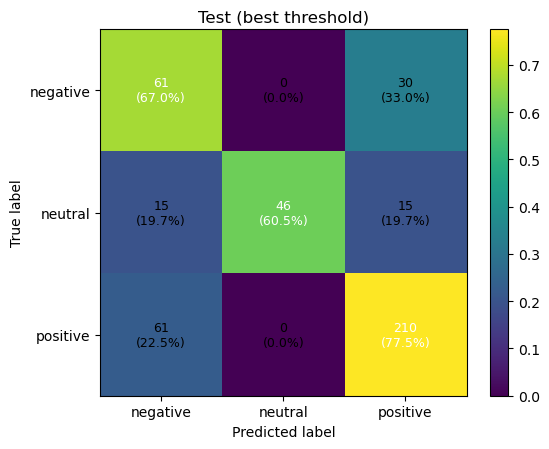

In [21]:
def plot_confusion(y_true, y_pred, title="Confusion (normalized)"):
    labels = ["negative","neutral","positive"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(figsize=(5.8,4.6))
    im = ax.imshow(cm_norm); ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(labels)), yticks=np.arange(len(labels)),
           xticklabels=labels, yticklabels=labels,
           ylabel="True label", xlabel="Predicted label", title=title)
    thr = cm_norm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,f"{cm[i,j]}\n({cm_norm[i,j]*100:.1f}%)",
                    ha="center",va="center",
                    color="white" if cm_norm[i,j]>thr else "black", fontsize=9)
    plt.tight_layout(); plt.show()

plot_confusion(yte, y_pred_test, "Test (best threshold)")


In [22]:
proba_test = pipe.predict_proba(Xte)
acc, f1_ma, f2_neg, y_pred_test = metrics_with_threshold(yte, proba_test, pipe.classes_, best["thr"])
rec_neg_test = recall_for_label(yte, y_pred_test, "negative")
print("\n=== TEST (GroupSplit) ===")
print(f"Accuracy : {acc:.3f}")
print(f"Macro-F1 : {f1_ma:.3f}")
print(f"Recall (negative) : {rec_neg_test:.3f}")
print(f"F2 (negative) : {f2_neg:.3f}")
print(classification_report(yte, y_pred_test, digits=3))



=== TEST (GroupSplit) ===
Accuracy : 0.724
Macro-F1 : 0.696
Recall (negative) : 0.670
F2 (negative) : 0.609
              precision    recall  f1-score   support

    negative      0.445     0.670     0.535        91
     neutral      1.000     0.605     0.754        76
    positive      0.824     0.775     0.798       271

    accuracy                          0.724       438
   macro avg      0.756     0.684     0.696       438
weighted avg      0.776     0.724     0.736       438



<p>
<u>Overall</u> — <b>Akurasi 0.724</b>, <b>Macro-F1 0.696</b>, <b>Recall (negative) 0.670</b>, dan <b>F2 (negative) 0.609</b>.
Ini mendekati target awal Macro-F1 ≈ 0.70 dan sudah memenuhi sasaran recall keluhan (≥ 0.65).
</p>

In [23]:
from datetime import datetime

# hitung recall negative di test
rec_neg_test = recall_for_label(yte, y_pred_test, "negative")

ARTIFACT = {
    "pipeline": pipe,
    "meta": {
        "model_version": "1.1.0",
        "created_at": datetime.now().isoformat(timespec="seconds"),
        "split": "group_by_product",
        "features": "TFIDF word(1-2) + char(3-5)",
        "class_order": list(pipe.classes_),

        # threshold profil
        "neg_threshold_high_recall": float(best["thr"]),   # dipakai saat ini
        # opsional: balanced (naikkan sedikit dari high-recall)
        "neg_threshold_balanced": float(min(best["thr"] + 0.03, 0.99)),

        # parameter training
        "neg_weight": float(best["neg_weight"]),
        "C": float(best["C"]),
        "lex_w": 0.0,

        # info preprocessing (opsional)
        "preproc": {
            "stopwords_size": len(STOPWORDS),
            "phrase_map_size": len(PHRASE_MAP)
        },

        # metrik test
        "test_metrics": {
            "accuracy": float(acc),
            "macro_f1": float(f1_ma),
            "f2_negative": float(f2_neg),
            "recall_negative": float(rec_neg_test)
        }
    }
}

joblib.dump(ARTIFACT, MODEL_PATH, compress=3)
print("Saved:", MODEL_PATH)


Saved: sentiment_pipeline_group.joblib
